In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

Set all the Constants

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

Import Data in tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset



In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Potatoes",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
#each element in the dataset is a tuple. 
# First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels 

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


In [7]:
print(image_batch[0])

tf.Tensor(
[[[142. 116. 117.]
  [137. 111. 112.]
  [107.  81.  82.]
  ...
  [173. 155. 151.]
  [182. 164. 160.]
  [196. 178. 174.]]

 [[138. 112. 113.]
  [137. 111. 112.]
  [132. 106. 107.]
  ...
  [175. 157. 153.]
  [177. 159. 155.]
  [185. 167. 163.]]

 [[117.  91.  92.]
  [112.  86.  87.]
  [144. 118. 119.]
  ...
  [176. 158. 154.]
  [176. 158. 154.]
  [181. 163. 159.]]

 ...

 [[107.  81.  80.]
  [146. 120. 119.]
  [126. 100.  99.]
  ...
  [163. 143. 142.]
  [167. 147. 146.]
  [171. 151. 150.]]

 [[115.  89.  88.]
  [124.  98.  97.]
  [160. 134. 133.]
  ...
  [161. 141. 140.]
  [165. 145. 144.]
  [169. 149. 148.]]

 [[116.  90.  89.]
  [136. 110. 109.]
  [137. 111. 110.]
  ...
  [158. 138. 137.]
  [161. 141. 140.]
  [164. 144. 143.]]], shape=(256, 256, 3), dtype=float32)


Visualize some of the images from our datasets

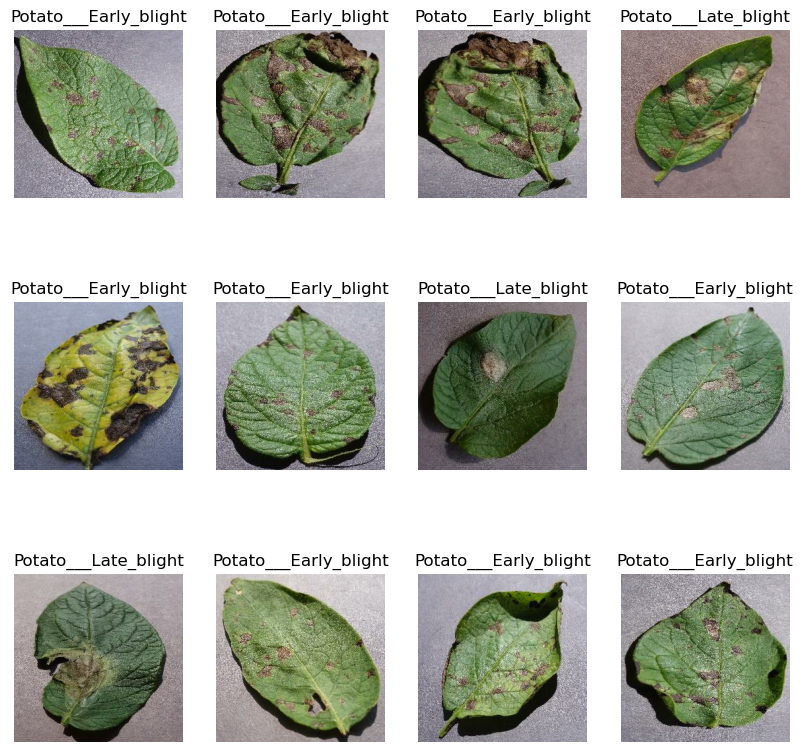

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

Training: Dataset to be used while training

In [9]:
len(dataset)

68

In [10]:
68*32

2176

In [11]:
dataset.take(10)

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [12]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [13]:
train_ds = dataset.take(54)
len(train_ds)

54

In [14]:
test_ds = dataset.skip(54)
len(test_ds)

14

Validation: Dataset to be tested against while training

In [15]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [16]:
val_ds = test_ds.take(6)
len(val_ds)

6

Test: Dataset to be tested against after we trained a model

In [17]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [20]:
len(train_ds)

54

In [21]:
len(val_ds)

6

In [22]:
len(test_ds)

8

Cache, Shuffle, and Prefetch the Dataset

In [23]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Building Model

Creating a Layer for Resizing and Normalization

In [24]:
#Resizing these images to the desired size Moreover, to improve model performance, we should normalize the image pixel value 
#(keeping them in range 0 and 1 by dividing by 256). 
#This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.
#We need to we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful 
#when we are done with the training and start using the model for predictions. At that time somone can supply an image 
#that is not (256,256) and this layer will resize it

In [25]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

Data Agumetation

In [26]:
#This step is needed when data is limited, this step will boosts the accuracy of our
#model by agumenting the data 

In [27]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

Applying Data Augmentation to Train Dataset

In [28]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

Model Architecture 

In [29]:
#We use a CNN coupled with a Softmax activation in the output layer. 
#We also add the initial layers for resizing, normalization and Data Augmentation.

In [30]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

Compiling the Model 

In [32]:
#Using adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [33]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [33]:
history = model.fit(
    train_ds, 
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 118s 2s/step - loss: 0.9088 - accuracy: 0.4948 - val_loss: 0.8124 - val_accuracy: 0.5052
Epoch 2/50
54/54 [==============================] - 117s 2s/step - loss: 0.6759 - accuracy: 0.6638 - val_loss: 0.6046 - val_accuracy: 0.6875
Epoch 3/50
54/54 [==============================] - 118s 2s/step - loss: 0.2784 - accuracy: 0.8912 - val_loss: 0.4891 - val_accuracy: 0.7917
Epoch 4/50
54/54 [==============================] - 118s 2s/step - loss: 0.1704 - accuracy: 0.9392 - val_loss: 0.2438 - val_accuracy: 0.9219
Epoch 5/50
54/54 [==============================] - 122s 2s/step - loss: 0.1636 - accuracy: 0.9369 - val_loss: 0.4316 - val_accuracy: 0.8542
Epoch 6/50
54/54 [==============================] - 103s 2s/step - loss: 0.2330 - accuracy: 0.9039 - val_loss: 0.3354 - val_accuracy: 0.8854
Epoch 7/50
54/54 [==============================] - 108s 2s/step - loss: 0.0972 - accuracy: 0.9618 - val_loss: 0.4399 - val_accuracy: 0.8750
Epoch 8/50
54

In [34]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 8s 373ms/step - loss: 0.0955 - accuracy: 0.9766


In [35]:
scores
#Scores is just a list containing loss and accuracy value

[0.0954628512263298, 0.9765625]

Plotting the Accuracy and Loss Curves

In [36]:
history

In [37]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [38]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [39]:
#loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

In [40]:
type(history.history['loss'])

list

In [41]:
len(history.history['loss'])

50

In [42]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.908845841884613,
 0.675918698310852,
 0.2784045934677124,
 0.1704188585281372,
 0.16356047987937927]

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

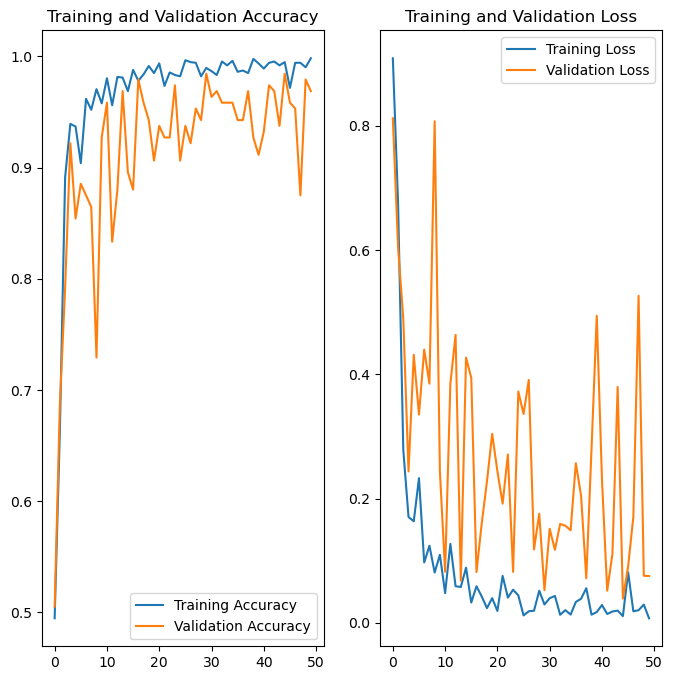

In [44]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Run prediction on a sample image

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 487ms/step
predicted label: Potato___Late_blight


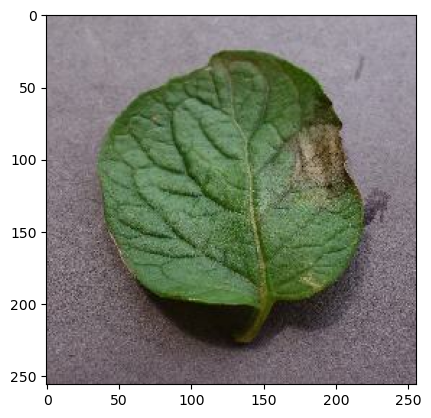

In [40]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

Write a function for inference

In [35]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 57ms/step


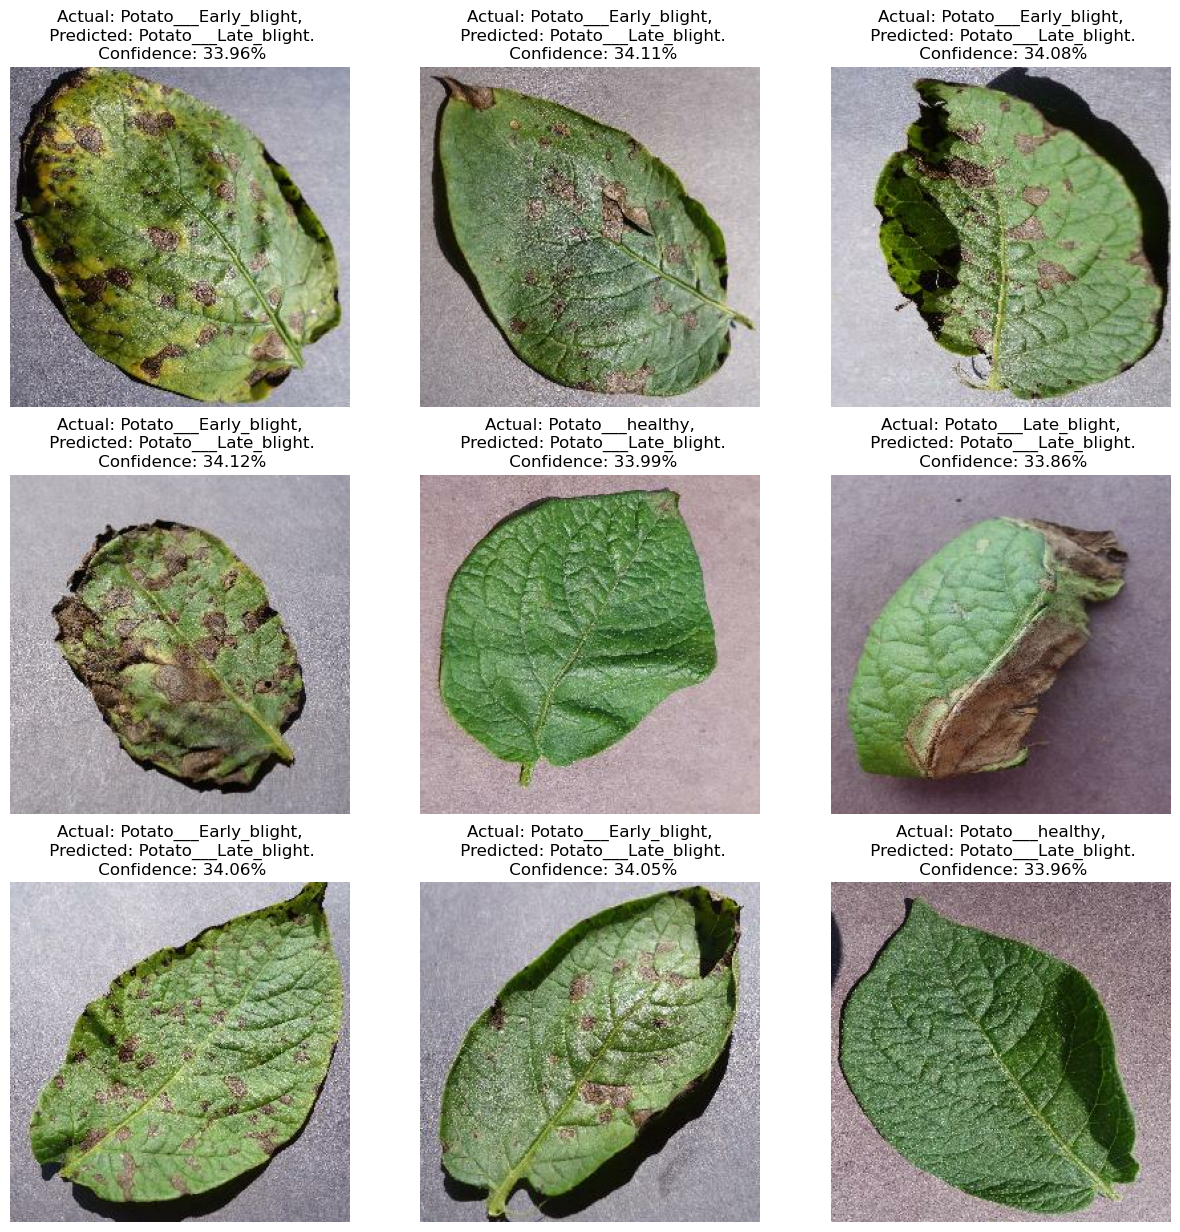

In [41]:
#Now run inference on few sample images
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")